In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from darts import TimeSeries
filename = "Ming25Jun67_total_order.csv"
df = pd.read_csv(f'../csv/{filename}')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   order_completed_at  541 non-null    object
 1   unique_order_count  541 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.6+ KB


In [3]:
print(df.shape)
print(df.head())
print(df.tail())

(541, 2)
  order_completed_at  unique_order_count
0         2023-01-01                  15
1         2023-01-02                  32
2         2023-01-03                  89
3         2023-01-04                  73
4         2023-01-05                  67
    order_completed_at  unique_order_count
536         2024-06-20                 120
537         2024-06-21                 152
538         2024-06-22                 138
539         2024-06-23                 126
540         2024-06-24                 149


In [4]:
df['order_completed_at'] = pd.to_datetime(df['order_completed_at'])
# make timeseries Object
series = TimeSeries.from_dataframe(df,
                                   time_col='order_completed_at',
                                   value_cols=['unique_order_count'],
                                   freq="D")

### remove outlier

In [5]:
# Function to replace outliers with the mean of the rest of the values
from scipy.stats import zscore
from darts import TimeSeries

def replace_outliers_with_mean(df, column_name):
    # Calculate Z-scores
    z_scores = zscore(df[column_name])
    
    # Identify outliers (using a threshold of 3 for Z-score)
    outliers = np.abs(z_scores) > 3
    
    # Calculate mean of non-outliers
    mean_non_outliers = df.loc[~outliers, column_name].mean()
    
    # Replace outliers with the mean of non-outliers
    df.loc[outliers, column_name] = mean_non_outliers
    
    return df

# Replace outliers in 'gmv' column
df_remove_out = replace_outliers_with_mean(df, 'unique_order_count')
series_remove_outlier = TimeSeries.from_dataframe(df_remove_out,
                                   time_col='order_completed_at',
                                   value_cols=['unique_order_count'],
                                   freq="D")

C:\Users\User\AppData\Local\Temp\ipykernel_7660\2557321846.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '142.47269303201506' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[outliers, column_name] = mean_non_outliers


In [6]:
from darts.dataprocessing.transformers import (Scaler,)

scaler = Scaler()
series = series_remove_outlier #!!!
series_rescaled = scaler.fit_transform(series)

series = series_rescaled #!!!

### test split

In [7]:
cut_off = pd.Timestamp("2024-05-01")
training, validation =series.split_before(cut_off)

In [8]:
#check date split
validation_df = validation.pd_dataframe()
training_df = training.pd_dataframe()
print(training_df.tail())
print(validation_df.head())
print(f'training set: {training_df.shape}')
print(f'validation set: {validation_df.shape}')

component           unique_order_count
order_completed_at                    
2024-04-26                    0.265347
2024-04-27                    0.207921
2024-04-28                    0.251485
2024-04-29                    0.229703
2024-04-30                    0.251485
component           unique_order_count
order_completed_at                    
2024-05-01                    0.231683
2024-05-02                    0.342574
2024-05-03                    0.261386
2024-05-04                    0.255446
2024-05-05                    0.350495
training set: (486, 1)
validation set: (55, 1)


### Viuslize data

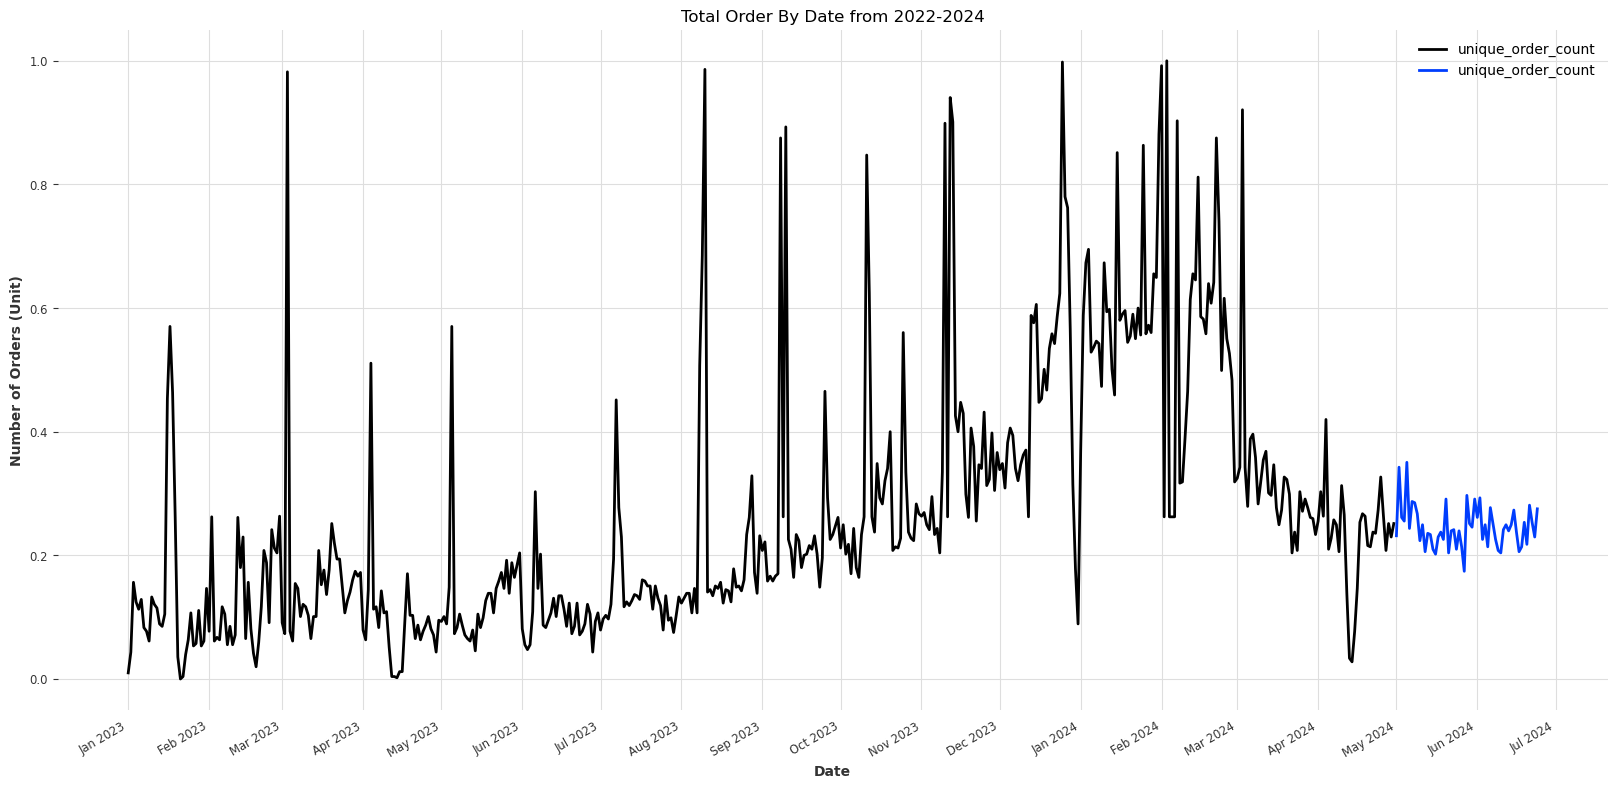

In [9]:
import matplotlib.dates as mdates

plt.figure(figsize=(20, 10))  # ปรับขนาดของภาพ (กว้าง x สูง)
training.plot()
validation.plot()

# ตั้งค่ารูปแบบของวันที่บนแกน x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # ปรับให้วันที่ไม่ซ้อนกัน

# กำหนด Title และชื่อของแกน x และ y
plt.title('Total Order By Date from 2022-2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders (Unit)')

plt.show()

# Model 

### Regression model

##### Linear Regression

In [17]:
from darts.models import (LinearRegressionModel,
                          CatBoostModel, 
                          LightGBMModel, 
                          XGBModel)
from darts.metrics import mape, mae, mse, mase
from math import sqrt

model_lst = [LinearRegressionModel, 
             CatBoostModel, 
             LightGBMModel,
             XGBModel]

# for m in model_lst:
#     model_name = m.__name__
#     print(model_name)
#     if model_name == "LinearRegressionModel":print(True)


model_param_dict = {
    0:{"lags": list(range(1, 36)),
        "output_chunk_length": [7],
        "random_state": [42]
        },
    1:{

    }
}

# def get_best_model():
#     parameters = {
#         "lags": list(range(1, 36)),
#         "output_chunk_length": [7],  # ทดลอง output_chunk_length ที่แตกต่างกัน
#         "random_state": [42]
#     }

#     best_parameter = LinearRegressionModel.gridsearch(
#         parameters=parameters,
#         series = series, #note (training + validation) X only training set!!!
#         start=cut_off,
#         forecast_horizon=7,
#         stride=1,          
#         last_points_only=False,  
#         metric=mse,
#         verbose=-1
#     )

LinearRegressionModel
True
CatBoostModel
LightGBMModel
XGBModel


In [ ]:
print(best_parameter)
best_model = best_parameter[0]

In [ ]:

# result from training , validation only
prediction = best_model.predict(len(validation))

mape_score = mape(validation, prediction)
print(f'score MAPE: {round(mape_score, 4)}')
print(f'score ACC: {100-(round(mape_score, 4))}')

mse_score = mse(validation, prediction)
print(f'score MSE: {round(mse_score, 4)}')

print(f'score RMSE: {round(sqrt(mse_score), 4)}')

mae_score = mae(validation, prediction)
print(f'score MAE: {round(mae_score, 4)}')